# Heads-Up

In the notebook, we are working on generating
graphs whose nodes have Euclidean coordinates;
One thing to pay attention to is, in real world
road network, nodes (intersections) that are close
to each other geographically are more likely to be
connected with edges (roads).

Edge centrality will be added as part of the heuristic.

# Questions

Does centrality really encode information about your destination?

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 21:25:47.764793. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [10]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 21:52:52.248342. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [100]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            G.add_edge(node, tmp_node[0], weight=weight)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 09:57:57.815936. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 10:18:11.580187. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


4
3
20
38


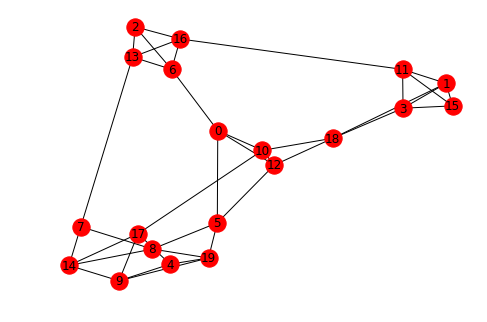

In [118]:
G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

In [134]:
def extract_path(prev, src, dst):
    
    path = []
    u = dst

    while prev[u] != src:
        path.insert(0, u)
        u = prev[u]
    
    path.insert(0, u)
    path.insert(0, src)
    return path

def bfs_beam_edges_path(G, src, dst):
    
    centrality = nx.edge_betweenness_centrality(G, weight='weight', \
                                              k=G.number_of_nodes(), \
                                            normalized=True)
    
    prev = [-1 for _ in range(G.number_of_nodes())]
    
    for u, v in nx.bfs_beam_edges(G, src, value=centrality.get):
        print(u, v, G.get_edge_data(u, v)['centrality'], G.get_edge_data(u, v)['weight'])
        prev[v] = u

    return extract_path(prev, src, dst)

for src in G.nodes():
    for dst in G.nodes():
        
        if src == dst:
            continue
        
        print(nx.dijkstra_path(G, src, dst, weight='weight'))
        print(bfs_beam_edges_path(G, src, dst))
        print('')

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 11:19:04.749858. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[0, 10, 18, 1]
(0, 10, 0.13157894736842105, 0.46121103947047337)
(0, 12, 0.0, 0.5662891132106116)
(0, 5, 0.10526315789473684, 0.09303607820567161)
(0, 6, 0.15789473684210525, 0.3816948443900896)
(10, 17, 0.34210526315789475, 0.10468498966407624)
(10, 18, 0.22105263157894736, 0.7152947828949262)
(5, 8, 0.02631578947368421, 0.6834648881128774)
(5, 19, 0.005263157894736842, 0.9666129116597154)
(6, 16, 0.07894736842105263, 0.7084908680478902)
(6, 2, 0.04736842105263158, 0.24600935449665373)
(6, 13, 0.02631578947368421, 0.8314588009217825)
(17, 9, 0.15789473684210525, 0.2067453667929282)
(17, 4, 0.09473684210526316, 0.6013852892562629)
(17, 14, 0.15789473684210525, 0.20545864098683964)
(18, 1, 0.24210526315789474, 0.007657185184694826)
(18, 3, 0.0, 0.9710776701083369)
(8, 7, 0.0, 0.6492326853850424)
(16, 11, 0.19999999999999998, 0.0639538696325408)
(1, 15, 0.05263157894736842, 0.40679467373723244)
[0, 10, 18, 1]

[0, 6, 2]
(0, 10, 0.13157894736842105, 0.46121103947047337)
(0, 12, 0.0, 0.566

In [132]:
for edge in G.edges(5):
    print(edge[0], edge[1], G.get_edge_data(edge[0], edge[1]))

(5, 0, {'weight': 0.09303607820567161, 'centrality': 0.10526315789473684})
(5, 8, {'weight': 0.6834648881128774, 'centrality': 0.02631578947368421})
(5, 19, {'weight': 0.9666129116597154, 'centrality': 0.005263157894736842})
(5, 12, {'weight': 0.348314977132694, 'centrality': 0.02631578947368421})


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 11:08:39.471563. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
